In [ ]:
# STEP 1: Install & authenticate Kaggle
!pip install -q kaggle

# Upload your Kaggle API key (kaggle.json)
from google.colab import files
files.upload()  # Upload the kaggle.json file

# Create kaggle folder and move the key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


# STEP 2: Download the Animals-10 dataset
!kaggle datasets download -d alessiocorrado99/animals10

# Unzip the dataset
!unzip -q animals10.zip -d animals10

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


In [ ]:
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

In [ ]:
directory=r"/content/animals10/raw-img"
batch_size = 32
img_size = 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    validation_split=0.15
)

In [ ]:
train_generator = datagen.flow_from_directory(
    directory,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    subset='training',
    class_mode='categorical'
)


validation_generator = datagen.flow_from_directory( directory,
  target_size=(img_size, img_size),
   batch_size=batch_size,
    shuffle=False,
   subset='validation',
   class_mode='categorical'
)

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


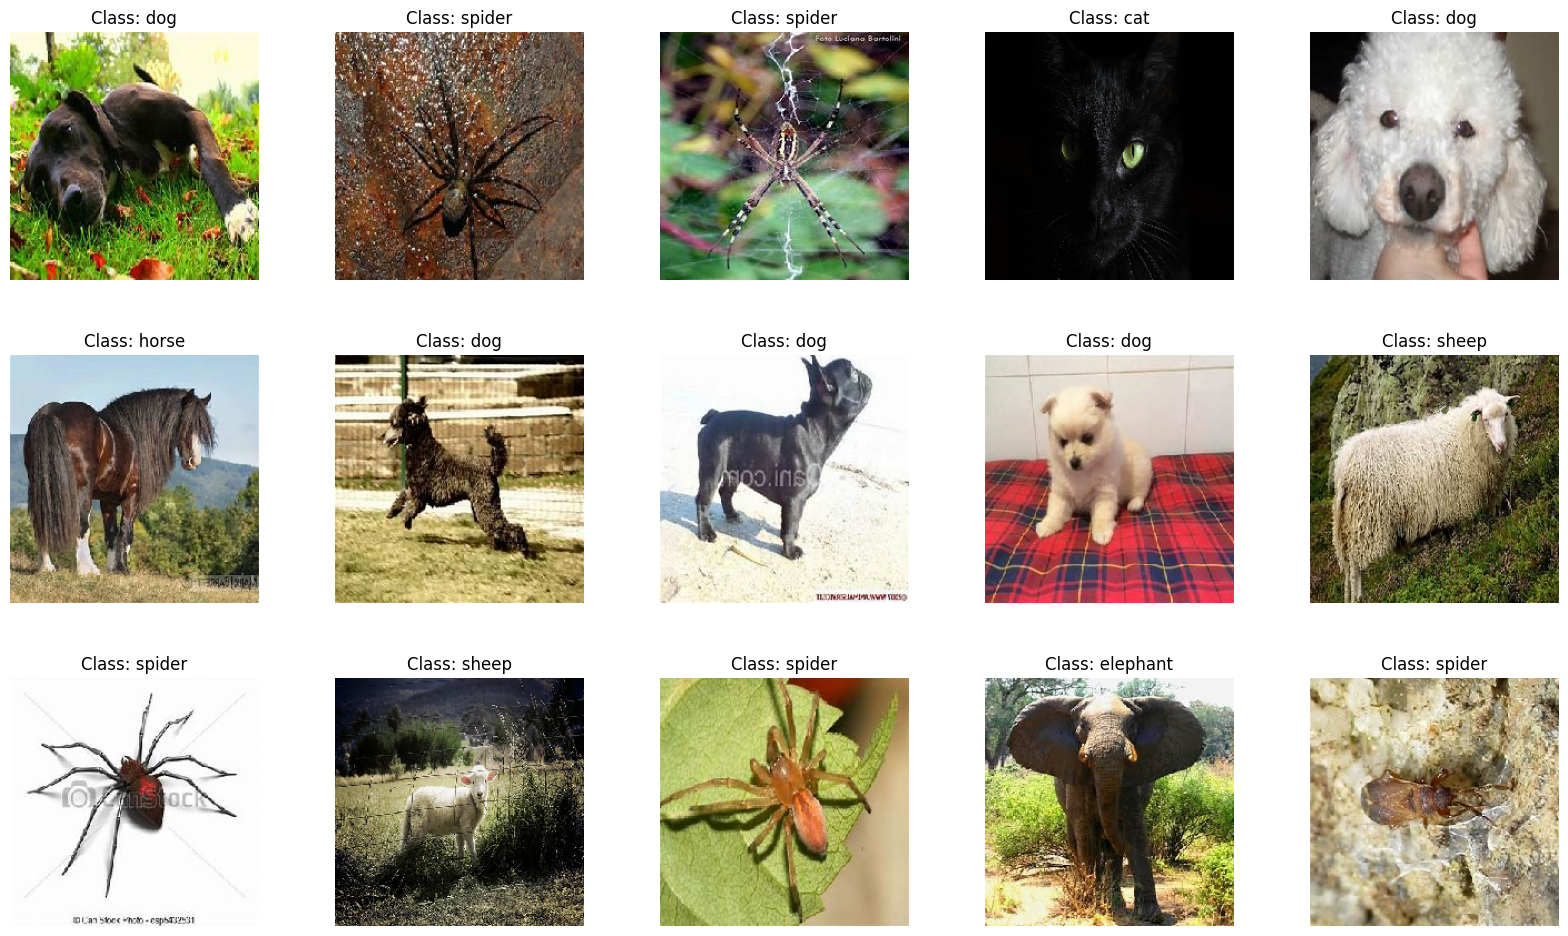

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
labels = [k for k in train_generator.class_indices]
translated_labels = [translate[label] for label in labels]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize=(20, 20))


for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {translated_labels[np.argmax(titles[i], axis=0)]}')
    plt.axis("off")

plt.show()

In [ ]:


import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input, Dropout,
                                     concatenate)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [ ]:
img_size = 224


base_model = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(img_size, img_size, 3))


base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_zfnet():
    model = Sequential([
        Conv2D(96, (7,7), strides=(2,2), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D((3,3), strides=(2,2)),
        Conv2D(256, (5,5), strides=(2,2), activation='relu'),
        MaxPooling2D((3,3), strides=(2,2)),
        Conv2D(384, (3,3), activation='relu'),
        Conv2D(384, (3,3), activation='relu'),
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D((3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def build_vgg16():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(base.input, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# --- Define Inception Module ---
def inception_module(x, f1, f3r, f3, f5r, f5, pool_proj):
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f3, (3,3), padding='same', activation='relu')(conv3)
    conv5 = Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    conv5 = Conv2D(f5, (5,5), padding='same', activation='relu')(conv5)
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = Conv2D(pool_proj, (1,1), padding='same', activation='relu')(pool)
    output = concatenate([conv1, conv3, conv5, pool], axis=3)
    return output

# --- Build Inception V1 Model ---
def build_inception_v1(input_shape=(224, 224, 3), num_classes=10):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = Conv2D(64, (1,1), activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)

    x = AveragePooling2D(pool_size=(7,7), strides=(1,1))(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(input_layer, x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
models = {
    "ZFNet": build_zfnet(),
    "VGG16": build_vgg16(),
    "InceptionV1": build_inception_v1()
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training ZFNet ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.2261 - loss: 2.2471 - val_accuracy: 0.3343 - val_loss: 1.8556 - learning_rate: 0.0010
Epoch 2/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 62s 90ms/step - accuracy: 0.3550 - loss: 1.8385 - val_accuracy: 0.3921 - val_loss: 1.7264 - learning_rate: 0.0010
Epoch 3/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.4067 - loss: 1.6904 - val_accuracy: 0.4151 - val_loss: 1.6455 - learning_rate: 0.0010
Epoch 4/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.4655 - loss: 1.5416 - val_accuracy: 0.4906 - val_loss: 1.4824 - learning_rate: 0.0010
Epoch 5/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 61s 88ms/step - accuracy: 0.5242 - loss: 1.4050 - val_accuracy: 0.5709 - val_loss: 1.2619 - learning_rate: 0.0010
Epoch 6/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.5604 - loss: 1.2975 - val_accuracy: 0.5745 - val_loss: 1.2563 - learning_rate: 0.0010
Epoch 7/20
696/696 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.5822 - l

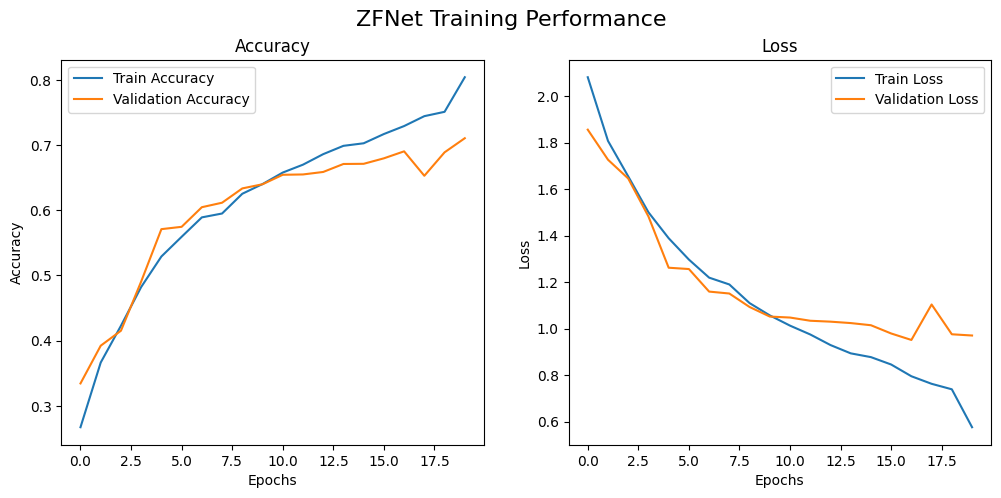

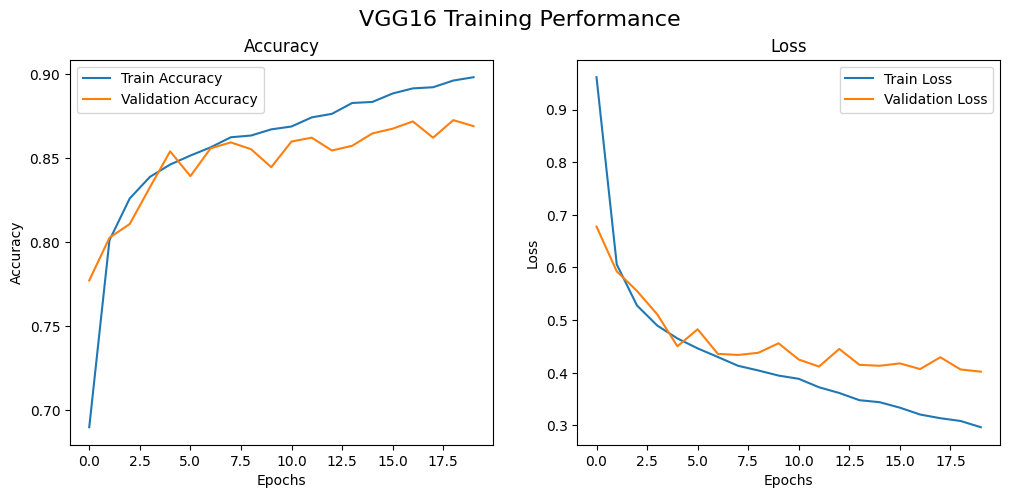

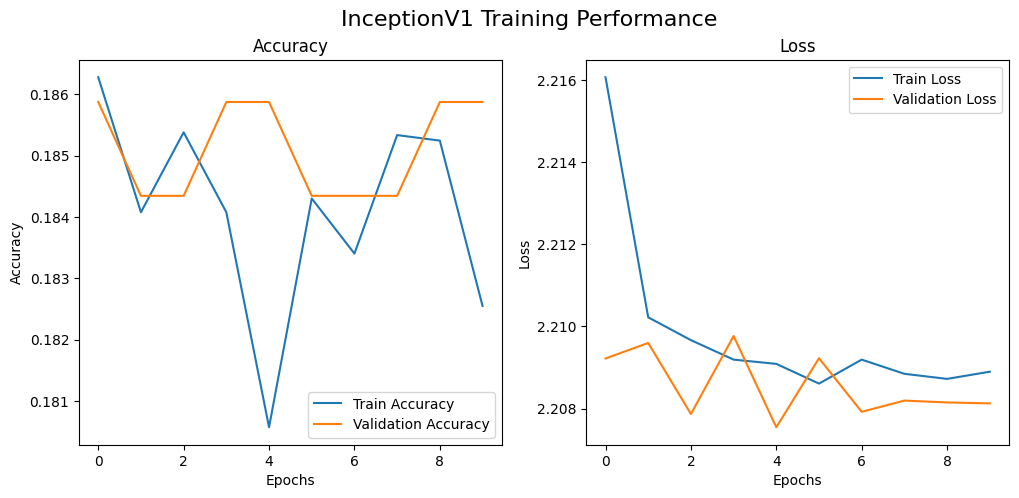


--- Final Evaluation Summary ---
ZFNet:
  Validation Accuracy: 0.6920
  Training Time: 1223.46 seconds

VGG16:
  Validation Accuracy: 0.8735
  Training Time: 3090.22 seconds

InceptionV1:
  Validation Accuracy: 0.1859
  Training Time: 860.20 seconds



In [ ]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
histories = {}
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    default_epochs = 20
    callbacks = []


    if name.lower() == "zfnet":
        epochs = 20
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
        ]
    else:
        epochs = default_epochs
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks
    )

    end_time = time.time()

    val_loss, val_acc = model.evaluate(validation_generator, verbose=0)
    print(f"{name} Validation Accuracy: {val_acc:.4f}")
    print(f"{name} Training Time: {end_time - start_time:.2f} seconds")


    histories[name] = history
    results[name] = {
        'val_accuracy': val_acc,
        'training_time': end_time - start_time
    }

    save_path = f'{name}_model.keras'
    model.save(save_path)
    print(f"{name} model saved to {save_path}")


def plot_histories(histories):
    for name, history in histories.items():
        plt.figure(figsize=(12, 5))
        plt.suptitle(f'{name} Training Performance', fontsize=16)

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

plot_histories(histories)

print("\n--- Final Evaluation Summary ---")
for name, data in results.items():
    print(f"{name}:")
    print(f"  Validation Accuracy: {data['val_accuracy']:.4f}")
    print(f"  Training Time: {data['training_time']:.2f} seconds\n")



--- Evaluating ZFNet ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step


<Figure size 1000x800 with 0 Axes>

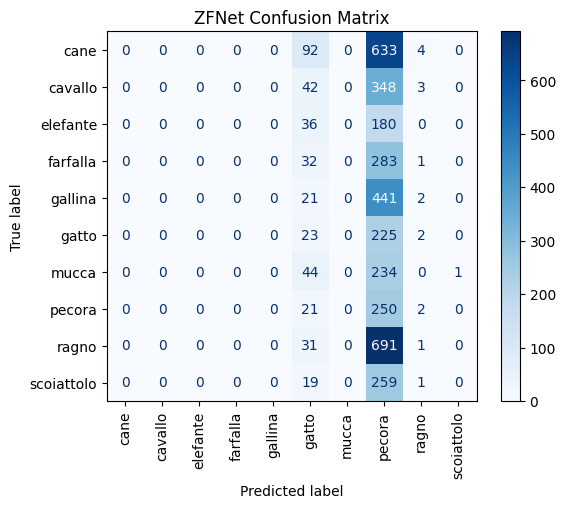

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- ZFNet Classification Report ---

              precision    recall  f1-score   support

        cane       0.00      0.00      0.00       729
     cavallo       0.00      0.00      0.00       393
    elefante       0.00      0.00      0.00       216
    farfalla       0.00      0.00      0.00       316
     gallina       0.00      0.00      0.00       464
       gatto       0.06      0.09      0.08       250
       mucca       0.00      0.00      0.00       279
      pecora       0.07      0.92      0.13       273
       ragno       0.06      0.00      0.00       723
  scoiattolo       0.00      0.00      0.00       279

    accuracy                           0.07      3922
   macro avg       0.02      0.10      0.02      3922
weighted avg       0.02      0.07      0.01      3922


--- Evaluating VGG16 ---
123/123 ━━━━━━━━━━━━━━━━━━━━ 2279s 19s/step


<Figure size 1000x800 with 0 Axes>

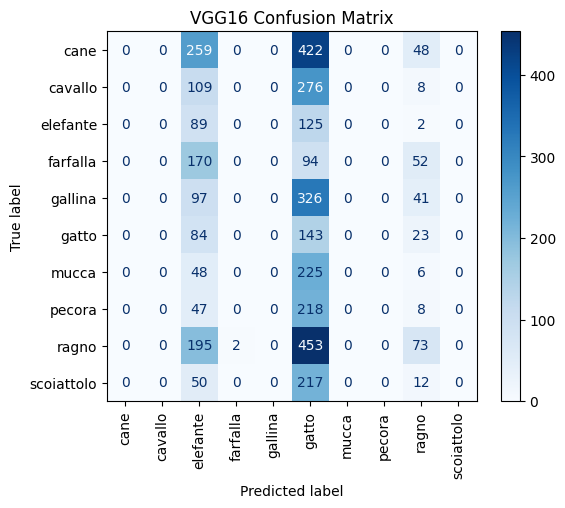

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- VGG16 Classification Report ---

              precision    recall  f1-score   support

        cane       0.00      0.00      0.00       729
     cavallo       0.00      0.00      0.00       393
    elefante       0.08      0.41      0.13       216
    farfalla       0.00      0.00      0.00       316
     gallina       0.00      0.00      0.00       464
       gatto       0.06      0.57      0.10       250
       mucca       0.00      0.00      0.00       279
      pecora       0.00      0.00      0.00       273
       ragno       0.27      0.10      0.15       723
  scoiattolo       0.00      0.00      0.00       279

    accuracy                           0.08      3922
   macro avg       0.04      0.11      0.04      3922
weighted avg       0.06      0.08      0.04      3922


--- Evaluating InceptionV1 ---
123/123 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step


<Figure size 1000x800 with 0 Axes>

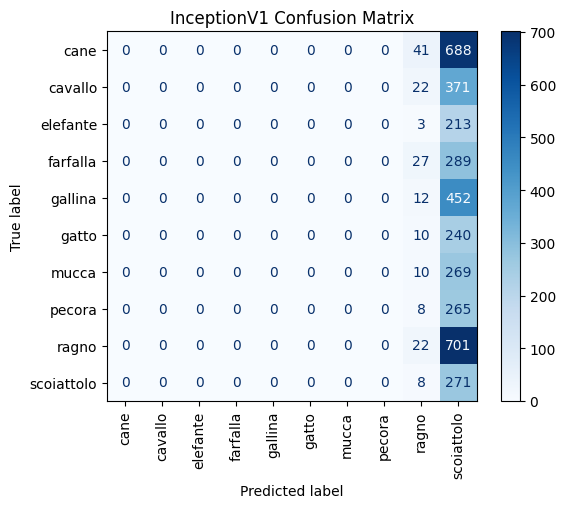

--- InceptionV1 Classification Report ---

              precision    recall  f1-score   support

        cane       0.00      0.00      0.00       729
     cavallo       0.00      0.00      0.00       393
    elefante       0.00      0.00      0.00       216
    farfalla       0.00      0.00      0.00       316
     gallina       0.00      0.00      0.00       464
       gatto       0.00      0.00      0.00       250
       mucca       0.00      0.00      0.00       279
      pecora       0.00      0.00      0.00       273
       ragno       0.13      0.03      0.05       723
  scoiattolo       0.07      0.97      0.13       279

    accuracy                           0.07      3922
   macro avg       0.02      0.10      0.02      3922
weighted avg       0.03      0.07      0.02      3922



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, generator, class_names, model_name):

    true_labels = generator.classes
    predictions = model.predict(generator, verbose=1)
    predicted_labels = np.argmax(predictions, axis=1)
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation='vertical', values_format='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print(f"--- {model_name} Classification Report ---\n")
    print(report)
class_names = list(validation_generator.class_indices.keys())

for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    evaluate_model(model, validation_generator, class_names, name)
